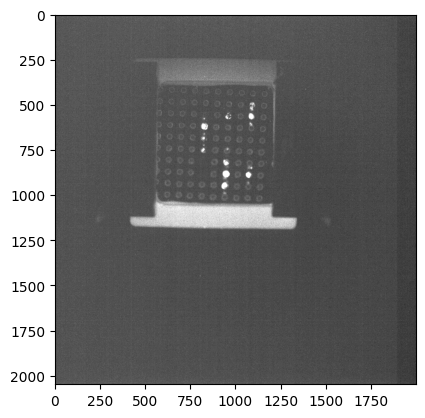

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

def open_fits_file(file_path):
    with fits.open(file_path, do_not_scale_image_data=True) as hdul:
        primary_hdu = hdul[0]
        image_data = primary_hdu.data

        bscale = primary_hdu.header.get('BSCALE', 1.0)
        bzero = primary_hdu.header.get('BZERO', 0.0)
        image_data = bscale * image_data + bzero
    return image_data

def scale_and_save(data, file_path, show=False):
    masked_image_data = np.ma.masked_invalid(data)
    mean_val = np.mean(masked_image_data)
    std_val = np.std(masked_image_data)
    vmin = mean_val - std_val
    vmax = mean_val + 2 * std_val

    scaled_data = np.clip(data, vmin, vmax)
    scaled_data = (scaled_data - vmin) / (vmax - vmin) 

    hdu = fits.PrimaryHDU(scaled_data)
    hdul = fits.HDUList([hdu])
    # hdul.writeto(f'{file_path[:-5]}_scaled.fits', overwrite=True)
    hdul.writeto(f'../images/experiment 9/output/with_signal_modified_{file_path[-6]}', overwrite=True)

    if show:
        plt.imshow(scaled_data, cmap='gray')
        plt.show()

file_path = '../images/experiment 9/100ms_without_BlackCover/with_signal_2.fits'
image = open_fits_file(file_path)
plt.imshow(image, cmap='gray')
scale_and_save(open_fits_file(file_path), file_path, show=True)


In [9]:
import cv2

def preprocess_image(image_data):
    # Normalize the image data to 8-bit
    norm_image = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    blurred = cv2.GaussianBlur(norm_image, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    return blurred, edges

def create_kernel(size, radius, thickness, background_value, boundary_value):
    kernel = np.full((size, size), background_value, dtype=np.float32)
    center = (size // 2, size // 2)
    cv2.circle(kernel, center, radius, boundary_value, thickness=thickness)
    
    return kernel

def calculate_loss(image_region, kernel):
    return np.mean((image_region - kernel) ** 2)

def detect_wells(image_data, kernel, threshold):
    detected_wells = []
    radius = kernel.shape[0] // 2
    for y in range(radius, image_data.shape[0] - radius):
        for x in range(radius, image_data.shape[1] - radius):
            image_region = image_data[y-radius:y+radius, x-radius:x+radius]
            loss = calculate_loss(image_region, kernel)
            if loss < threshold:
                detected_wells.append((x, y))
    return detected_wells

def plot_detected_wells(image_data, detected_wells, radius):
    output_image = cv2.cvtColor(image_data, cv2.COLOR_GRAY2BGR)
    for (x, y) in detected_wells:
        cv2.circle(output_image, (x, y), radius, (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.title('Detected Wells')
    plt.imshow(output_image)
    plt.show()

# Parameters
radius = 15
margin = 3
background_value = 500 
boundary_value = 1000
threshold = 1000 

# Process
image_data = open_fits_file(file_path)
kernel = create_kernel(radius, margin, background_value, boundary_value)
print(kernel.shape)
# detected_wells = detect_wells(image_data, kernel, threshold)
# plot_detected_wells(image_data, detected_wells, radius)


(30, 30)


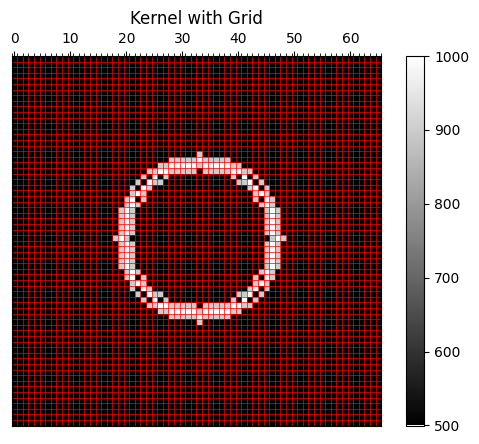

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_kernel(size, radius, thickness, background_value, boundary_value):
    kernel = np.full((size, size), background_value, dtype=np.float32)
    center = (size // 2, size // 2)
    cv2.circle(kernel, center, radius, boundary_value*0.9, thickness=1)
    cv2.circle(kernel, center, radius - 1, boundary_value, thickness=1)
    cv2.circle(kernel, center, radius - 2, boundary_value*0.9, thickness=1)
    
    return kernel

def plot_kernel_with_grid(kernel):
    fig, ax = plt.subplots()
    cax = ax.matshow(kernel, cmap='gray')

    # Add a colorbar
    fig.colorbar(cax)

    # Set minor ticks to create the grid
    ax.set_xticks(np.arange(-.5, kernel.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, kernel.shape[0], 1), minor=True)

    # Grid lines based on minor ticks
    ax.grid(which='minor', color='red', linestyle='-', linewidth=0.5)

    # Ensure that ticks and grid lines align with the image
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Show the plot
    plt.title('Kernel with Grid')
    plt.gca().invert_yaxis()  # Optional: Match the image coordinate system
    plt.show()

# Parameters
size = 66
radius = 15
thickness = 2
background_value = 500
boundary_value = 1000

# Create the kernel
kernel = create_kernel(size, radius, thickness, background_value, boundary_value)

# Plot the kernel with a grid
plot_kernel_with_grid(kernel)


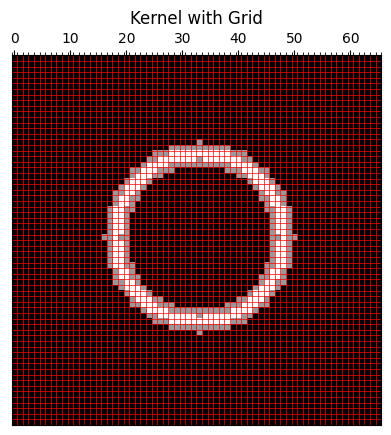

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def create_gradient_circle(size, radius, thickness, background_value, boundary_value):
    kernel = np.full((size, size), background_value, dtype=np.float32)
    center = (size // 2, size // 2)
    
    inner_radius = radius - thickness // 2
    outer_radius = radius + thickness // 2
    
    for i in range(size):
        for j in range(size):
            dist = np.sqrt((i - center[0])**2 + (j - center[1])**2)
            if inner_radius <= dist <= outer_radius:
                if dist <= inner_radius + 1:
                    kernel[i, j] = boundary_value * 0.8 
                elif dist >= outer_radius - 1:
                    kernel[i, j] = boundary_value  * 0.8
                else:
                    kernel[i, j] = boundary_value  
    
    return kernel

def plot_kernel_with_grid(kernel):
    fig, ax = plt.subplots()
    cax = ax.matshow(kernel, cmap='gray')

    ax.set_xticks(np.arange(-.5, kernel.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, kernel.shape[0], 1), minor=True)

    ax.grid(which='minor', color='red', linestyle='-', linewidth=0.5)

    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.title('Kernel with Grid')
    plt.gca().invert_yaxis()
    plt.show()

# Parameters
size = 66
radius = 15
thickness = 4
background_value = 500
boundary_value = 1000  

kernel = create_gradient_circle(size, radius, thickness, background_value, boundary_value)

plot_kernel_with_grid(kernel)
